# Testing software

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sources

In [27]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [28]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.4, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(1E47 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(1E5 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.42344, Emin, Emax)
my_sources = Sources()
my_sources.add(point_source)
my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 
my_sources.add_atmospheric_component() # auto atmo component

In [29]:
my_sources.associated_fraction()

<Quantity 0.13348575>

## Simulation

In [141]:
from python.simulation import Simulation
from python.detector_model import NorthernTracksDetectorModel

In [180]:
obs_time = 10 * u.year
sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim.setup_and_run()
sim.save("output/test_sim_file.h5")

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [181]:

#sim._sim_output.stan_variable("event").values.reshape(3, )

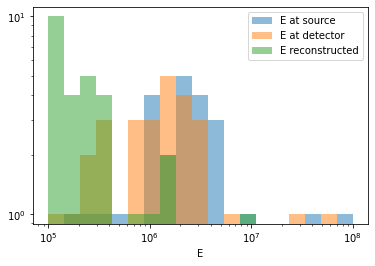

In [182]:
fig, ax = sim.show_spectrum()

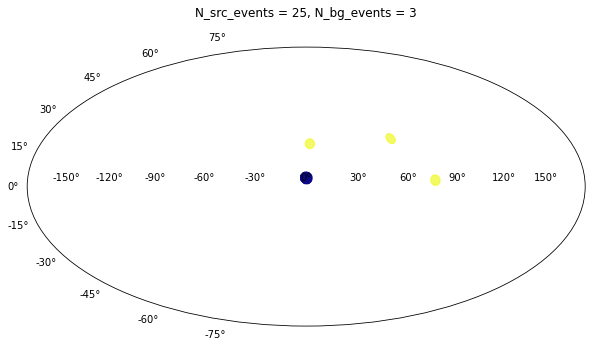

In [183]:
fig, ax = sim.show_skymap()

## Fit 

In [9]:
from python.events import Events
from python.fit import StanFit
from python.detector_model import NorthernTracksDetectorModel

In [10]:
events = Events.from_file("output/test_sim_file.h5")
obs_time = 10 * u.year

In [11]:
fit = StanFit(my_sources, NorthernTracksDetectorModel, events, obs_time)
#fit.setup_and_run()

In [12]:
fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()

Using cached StanModel


In [13]:
#fit.run(chains=2)

## Debugging multiple chains

In [14]:
from cmdstanpy import CmdStanModel

In [15]:
fit._fit_filename

'stan_files/model_code.stan'

In [16]:
new_model = CmdStanModel(stan_file = fit._fit_filename)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code


In [25]:
fit_inputs = fit._get_fit_inputs()
fit_inputs = {k: v if not isinstance(v, np.ndarray) else v.tolist() 
              for k,v in fit_inputs.items()}
fit_inputs["integral_grid"] = [_.tolist() for _ in fit_inputs["integral_grid"]]

#fit_inputs

In [24]:
new_model.sample(data=fit_inputs, iter_sampling=500, chains=2, show_progress=True)

Chain 2 -   done: 100%|██████████| 1500/1500 [03:57<00:00,  6.30it/s]


CmdStanMCMC: model=model_code chains=2['method=sample', 'num_samples=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpenwvff2s/model_code-202010261927-1-7c_0t77h.csv
	/var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpenwvff2s/model_code-202010261927-2-c24srteu.csv
 output_files:
	/var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpenwvff2s/model_code-202010261927-1-7c_0t77h-stdout.txt
	/var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpenwvff2s/model_code-202010261927-2-c24srteu-stdout.txt

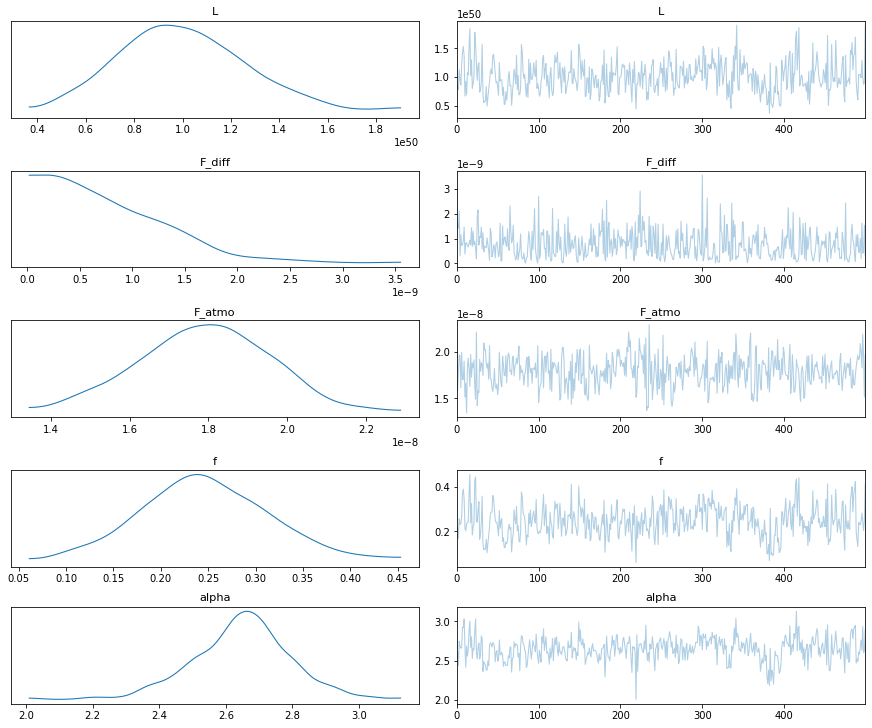

In [87]:
fit.plot_trace(var_names=["L", "F_diff", "F_atmo", "f", "alpha"])

In [89]:
fit.save("output/test_fit_file.h5")

We can check the results of the fit against the known true values from the above simulation.

In [90]:
from python.simulation import SimInfo

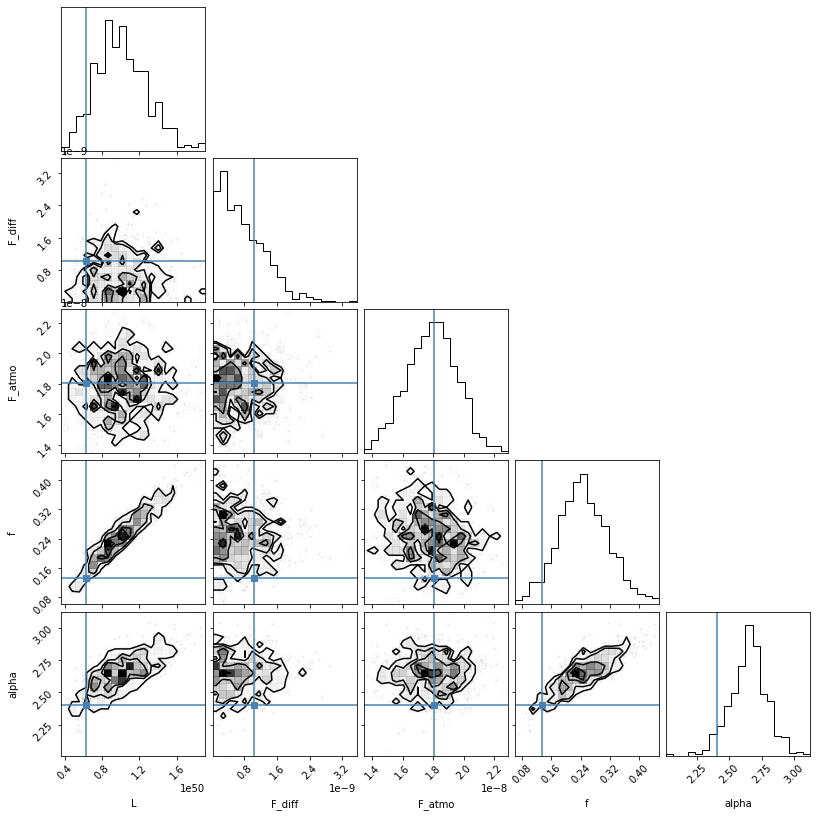

In [91]:
sim_info = SimInfo.from_file("output/test_sim_file.h5")
fig = fit.corner_plot(truths=sim_info.truths)

Similarly, we can use the simulation info to check the classification of individual events.

In [92]:
fit.check_classification(sim_info.outputs)

Event 3 is misclassified
P(src0) = 0.000000
P(diff) = 0.160727
P(atmo) = 0.839273
A total of 1 events are misclassified
